# Neural Machine Translation with Attention

- Attention model에 대해서 간략히 설명하고 keras와 eager execution을 통해서 Korean to English 번역기를 만들어 보겠습니다.

## Attention Model 기본 설명

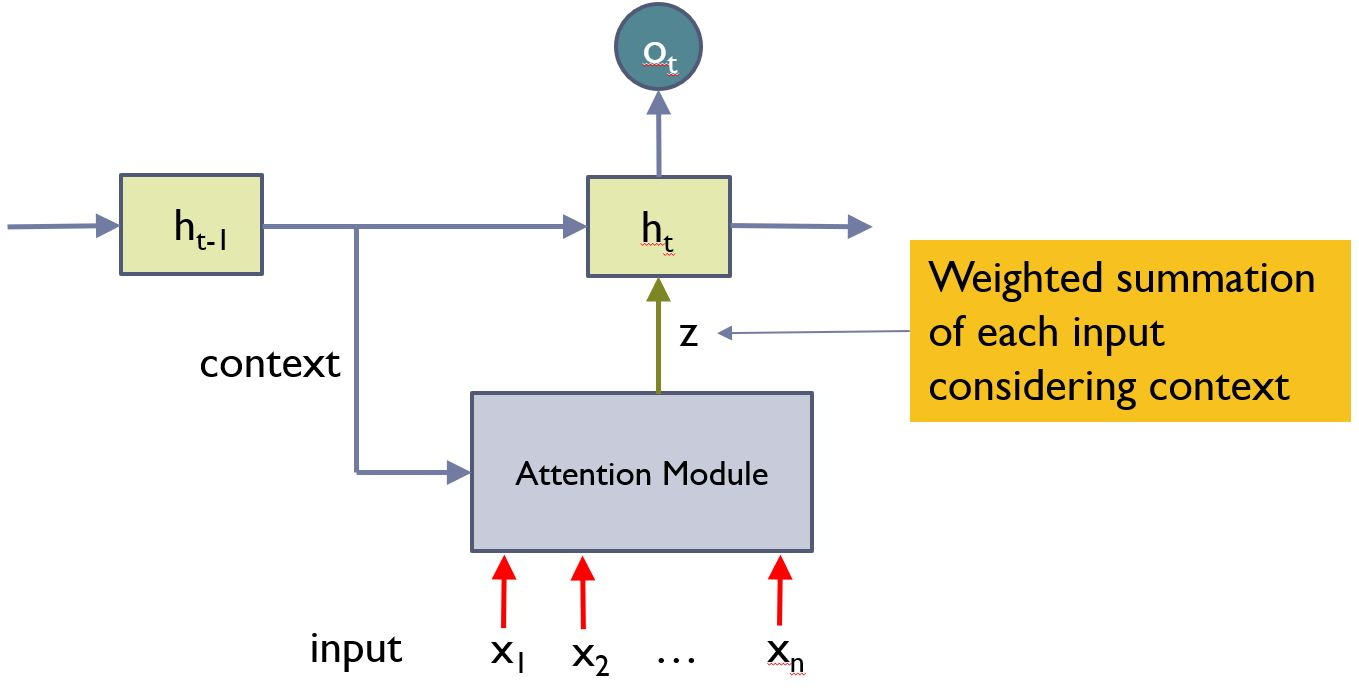

### 1)"I go to school" 이라는 문장을 "나는 학교 에 간다"로 번역을 한다면, h(t-1)에서 "나는"이라는 O(t-1) 결과값이 나왔으면 context는 "나는"의 벡터가 들어간다.
### 2) input에는 x1~x4까지 "I"벡터, "go"벡터,  "to"벡터, "school"벡터가 모든 Attention Module에 동일하게 들어간다.
### 3) 좀더 자세하게 inside를 보면

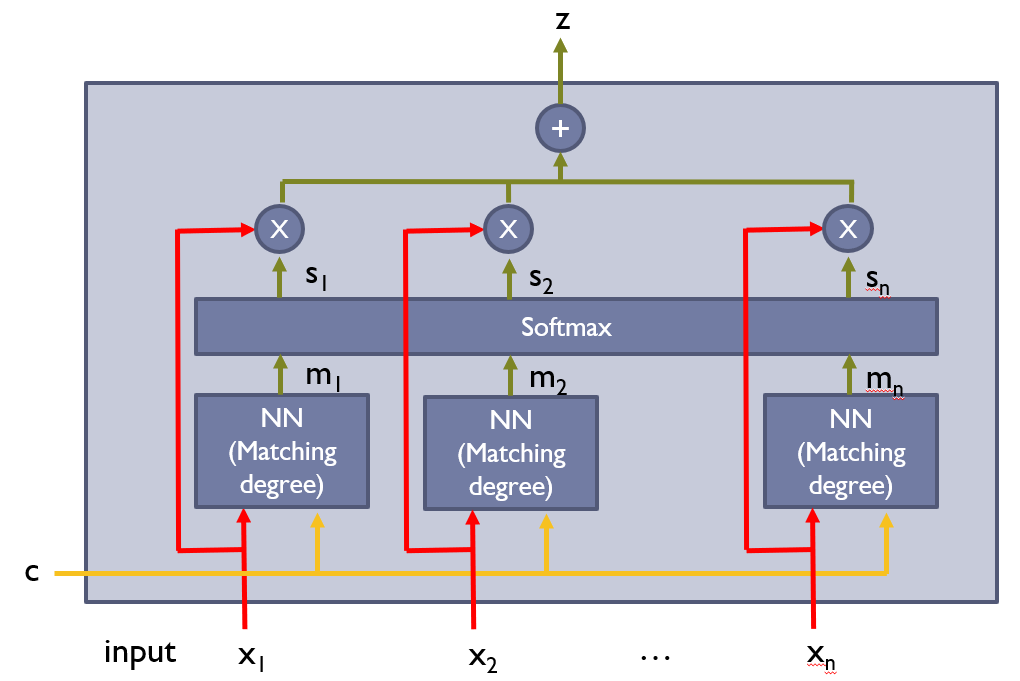

- **c: "나는"의 벡터값**
- **x1: "I" 벡터값 [1,0,0,0],  x2: "go" 벡터값 [0,1,0,0], x3: "to" 벡터값 [0,0,1,0], x4: "school" 벡터값 [0,0,0,1]**

### 첫번째, NN(Matching degree)에서 inner product를 Matching degree를 측정한다 치면 m1은 "나는"과 "I"의 연관도를 출력한다.
### 두번째, m1, ..., m4까지 Matching degree를 출력하고 Softmax에 넣어서 확률합이 "1"이되도록 s1, ...,s4를 출력한다.
### 세번째, "나는" 다음에 "학교"를 예측해야하므로 s4의 확률이 높게 나와야한다.(처음에는 아니겠지만)
- 예를 들어 s1은 0.05, s2는 0.1, s3는 0.05, s4는 0.8이 나온다고 하면

### 네번째, x4인 "school"에 s4(0.8)을 해주면 x4에 Attention이 될 것이다.


In [19]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
# %tensorflow_version 1.x  --> 코렙에서 1.x버전 사용하고 싶을때

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.13.2


In [37]:
tf.test.is_gpu_available()

True

## 데이터셋 다운로드
- http://www.manythings.org/anki/
- 해당 데이터를 보면 전처리가 필요하다.
- 1) 각 문장에 시작과 끝을 알리는 토큰 추가
- 2) 특수문자 제거
- 3) 단어 색인 및 역 단어 색인 (단어-id, id-단어)
- 4) 각 문장을 최대 길이까지 채움

```
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
```

### 한글이 다운로드 안되서 그냥 다운로드 받아 압축품

In [20]:
# Download the file
path_to_zip = './data'
path_to_file = os.path.dirname(path_to_zip) + "/data/kor_.txt"  #/spa.txt, kor.txt

In [21]:
a = open(path_to_file, encoding='UTF-8').read().strip().split('\n')
with open('./data/kor_.txt', 'w', encoding='utf-8') as file:
    for i in a:
        b = i.split('\tCC-BY')
        file.writelines(b[0]+'\n')

## 전처리 하기

In [22]:
# Convert the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

- 유니코드 정규화는 모양이 같은 여러 문자들이 있을 경우 이를 기준에 따라 하나로 통합해 주는 일을 가리킨다. 그 기준으로는 아래 표와 같이 NFD, NFC, NFKD, NFKC가 있다.
- NFD로의 정규화 : 코드를 정준 분해한다
###### 한글을 한글 소리마디 영역(U+AC00~U+D7A3)으로 썼을 경우, 이를 첫가끝 코드로 처리하기
- 위 (U+C704) → ᄋ (U+110B) + ᅱ (U+1171)
- 한 (U+D55C) → ᄒ (U+1112) + ᅡ (U+1161) + ᆫ (U+11AB)
```
unicodedata.normalize('NFD', '한글')
```

In [23]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # 단어와 부호 간의 한칸 띄우기 아래에 (예시1) 참조
    w = re.sub(r"([?.!])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 공간을 공백으로 교체
    w = re.sub(r"[^[가-힣]?.!]+", " ", w)   #알파벳:^a-zA-Z, 한글:^[가-힣]
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    print(w)
    return(w)

(예시1)
```
w = "나는 학교!에 간!  > < 다?   ?."
w = re.sub(r"([?.!])", r" \1 ", w)
w1 = re.sub(r'[" "]+', " ", w)
w2 = re.sub(r"[^[가-힣]?.!]+", " ", w)
w3 = w2.rstrip().strip()
w4 = '<start>' + w3 + '<end>'
```
ouput
```
나는 학교 ! 에 간 !   > < 다 ?     ?  . 
나는 학교 ! 에 간 ! > < 다 ? ? . 
나는 학교 ! 에 간 !   > < 다 ?     ?  . 
나는 학교 ! 에 간 !   > < 다 ?     ?  .
<start>나는 학교 ! 에 간 !   > < 다 ?     ?  .<end>
```

- 1) 악센트 제거
- 2) 문장을 정리
- 3) 단어 쌍으로 반환(단어와 index, index와 단어 맵핑)

In [24]:
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in I.split('\t')] 
                  for I in lines[:num_examples]]
    len(word_pairs)
    return word_pairs

```
lines = ["school\t학교", "bat\t방망이", "car\t자동차"]
num_examples = 4
word_pairs = [[preprocess_sentence(w) for w in I.split('\t')]
             for I in lines[:num_examples]]
=
word_pairs = []
for I in lines[:num_examples]:
    word = []
    for w in I.split('\t'):
        word.append(preprocess_sentence(w))
    word_pairs.append(word)
print(word_pairs)
        ```
output
```
[['<start>school<end>', '<start>학교<end>'], ['<start>bat<end>', '<start>방망이<end>'], ['<start>car<end>', '<start>자동차<end>']]
```

In [25]:
# index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
            
        self.vocab = sorted(self.vocab)
        
        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1
        
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
        print(self.vocab)

- update는 집합에서 가능
```
a = ["나는 학교에 간다.", "엄마 어딨어요?", "우리들은 1학년"]
voca = set()
for p in a:
    voca.update(p.split(' '))
print(voca)
```
output
```
{'1학년', '간다.', '나는', '어딨어요?', '엄마', '우리들은', '학교에'}
```

```
a = ["나는 학교에 간다.", "엄마 어딨어요?", "우리들은 1학년"]
voca = set()
for p in a:
    voca.update(p.split(' '))
# voca : {'나는', '엄마', '우리들은', '1학년', '어딨어요?', '학교에', '간다.'}
voca = sorted(voca)
# voca : ['1학년', '간다.', '나는', '어딨어요?', '엄마', '우리들은', '학교에']
w2i = {}
i2w = {}
w2i['<pad>'] = 0
for index, word in enumerate(voca):
    w2i[word] = index + 1
for word, index in w2i.items():
    i2w[index] = word
```
output
```
{'<pad>': 0,
 '1학년': 1,
 '간다.': 2,
 '나는': 3,
 '어딨어요?': 4,
 '엄마': 5,
 '우리들은': 6,
 '학교에': 7}
 ```
 ```
 {0: '<pad>',
 1: '1학년',
 2: '간다.',
 3: '나는',
 4: '어딨어요?',
 5: '엄마',
 6: '우리들은',
 7: '학교에'}
 ```

In [26]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path, num_examples):
    # 정리된 input, output 쌍 생성 (전처리)
    pairs = create_dataset(path, num_examples)
    
    # 언어쌍별 인덱싱 작업
    inp_lang = LanguageIndex(ko for en, ko in pairs)
    targ_lang = LanguageIndex(en for en, ko in pairs)
    
    # input, target 언어의 벡터화
    # 한글 문장
    input_tensor = [[inp_lang.word2idx[s] for s in ko.split(' ')] for en, ko in pairs]
    # 영어 문장
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, ko in pairs]
    
    # input & output tensor의 max_length 계산
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # input & output을 max_length를 기준으로 padding작업
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                maxlen=max_length_inp,
                                                                padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                 maxlen=max_length_tar,
                                                                 padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

    

## 테스트할 속도를 높이기 위해 데이터 사이즈를 줄이기(옵션)
- 100000문장 데이터셋을 훈련하는데 시간이 오래 걸리는 30000문장만으로 훈련(속도는 증가하나 번역품질은 떨어짐)

In [60]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

<start> go . <end>
<start> 가 . <end>
<start> hi . <end>
<start> 안녕 . <end>
<start> run ! <end>
<start> 뛰어 ! <end>
<start> run . <end>
<start> 뛰어 . <end>
<start> who ? <end>
<start> 누구 ? <end>
<start> wow ! <end>
<start> 우와 ! <end>
<start> fire ! <end>
<start> 쏴 ! <end>
<start> help ! <end>
<start> 도와줘 ! <end>
<start> jump ! <end>
<start> 점프 ! <end>
<start> jump . <end>
<start> 점프해 . <end>
<start> wait ! <end>
<start> 기다려 ! <end>
<start> wait ! <end>
<start> 잠깐 ! <end>
<start> wait . <end>
<start> 기다려 . <end>
<start> begin . <end>
<start> 시작해 . <end>
<start> hello ! <end>
<start> 안녕 ! <end>
<start> i see . <end>
<start> 알았어 . <end>
<start> i try . <end>
<start> 시도해볼게 . <end>
<start> i won ! <end>
<start> 내가 이겼어 ! <end>
<start> oh no ! <end>
<start> 아니 이런 ! <end>
<start> relax . <end>
<start> 진정해 . <end>
<start> shoot ! <end>
<start> 쏴 ! <end>
<start> smile . <end>
<start> 웃어 . <end>
<start> attack ! <end>
<start> ᄀ

<start> 와서 이것좀 봐 . <end>
<start> do you have proof ? <end>
<start> 증거 있어 ? <end>
<start> do you work alone ? <end>
<start> 혼자서 일해 ? <end>
<start> does tom like you ? <end>
<start> 톰은 너 좋아해 ? <end>
<start> don't be so silly . <end>
<start> 실없게 굴지마 . <end>
<start> don't even try it . <end>
<start> 시도조차 하지마 . <end>
<start> everybody laughed . <end>
<start> 전부 웃었어 . <end>
<start> everyone screamed . <end>
<start> 모두 비명을 질렀어 . <end>
<start> everyone survived . <end>
<start> 모두 살아남았어 . <end>
<start> everyone survived . <end>
<start> 모두가 살아남았어 . <end>
<start> everyone survived . <end>
<start> 모두들 살아남았어 . <end>
<start> exercise outdoors . <end>
<start> 밖에서 운동해 . <end>
<start> god bless you all . <end>
<start> 신의 가호가 있길 . <end>
<start> goodnight, mother . <end>
<start> 엄마 잘자 . <end>
<start> he died yesterday . <end>
<start> 그는 어제 죽었어 <end>
<start> her nails are r

<start> we have a party tonight . <end>
<start> 우리 오늘 밤에 파티가 있어 . <end>
<start> we'll take care of that . <end>
<start> 우리가 그것을 맡겠다 . (처리하겠다 . ) <end>
<start> what do you want to eat ? <end>
<start> 뭐 먹고 싶어 ? <end>
<start> what does it consist of ? <end>
<start> 뭘로 구성되어 있어 ? <end>
<start> what we need is a break . <end>
<start> 우리한테 필요한 건 휴식이야 . <end>
<start> what's the horse's name ? <end>
<start> 그 말의 이름이 뭐야 ? <end>
<start> where do you want to go ? <end>
<start> 너 어디 가고 싶니 ? <end>
<start> why is he staring at me ? <end>
<start> 그는 왜 날 쳐다보는 거지 ? <end>
<start> yes, that's what i mean . <end>
<start> 그래, 그게 내가 말하려던 것이었어 . <end>
<start> you need to be prepared . <end>
<start> 넌 준비해야 돼 . <end>
<start> you seemed to be lonely . <end>
<start> 네가 외로워 보였어 . <end>
<start> you should stop singing . <end>
<start> 너 노래 그만 불러야할 것 같아 . <end>
<start>

<start> i'd like to learn how to ski . <end>
<start> 나는 스키타는 법을 배우고 싶어 . <end>
<start> i'm going to bed . good night . <end>
<start> 나 자러 갈게 . 잘자 . <end>
<start> i'm just watching television . <end>
<start> 난 그냥 티비 보고 있어 . <end>
<start> i'm just watching television . <end>
<start> 난 그냥 티비를 보고 있어 . <end>
<start> i'm little worried about you . <end>
<start> 나는 조금 네가 걱정돼 . <end>
<start> i'm not going to go in there . <end>
<start> 난 거기에 안 들어갈 거야 . <end>
<start> i'm so glad that you're here . <end>
<start> 와줘서 고마워 . <end>
<start> i'm sorry i left without you . <end>
<start> 너 빼고 가버려서 미안해 . <end>
<start> i've heard this joke already . <end>
<start> 이 농담은 이미 들어봤어 . <end>
<start> i've suffered as much as you . <end>
<start> 나는 너만큼 고생했어 . <end>
<start> it was a rhetorical question . <end>
<start> 이건 수사적인 질문이었어 . <end>
<start> it was inevitable, wasn't i

<start> 우린 좀 적응을 해야겠어 . <end>
<start> we solved that problem in a week . <end>
<start> 우리는 그 문제를 일주일 안에 해결했다 . <end>
<start> what was the matter this morning ? <end>
<start> 아침에 무슨 일이 있었니 ? <end>
<start> what's the best way to get there ? <end>
<start> 거기에 갈 수 있는 가장 좋은 방법이 뭐야 ? <end>
<start> where in the world have you been ? <end>
<start> 세상에 너 어디에 있었니 ? <end>
<start> who would do something like this ? <end>
<start> 누가 저런 걸 하겠어 ? <end>
<start> why does tom hate boston so much ? <end>
<start> 왜 톰은 보스턴을 그렇게나 싫어해 ? <end>
<start> why is tom afraid to go to sleep ? <end>
<start> 왜 톰은 자는 것을 두려워할까 ? <end>
<start> would you like to try doing that ? <end>
<start> 그걸 시도해보고 싶니 ? <end>
<start> you can't imagine how busy i was . <end>
<start> 내가 얼마나 바빴는지 상상도 못 할 걸 ? <end>
<start> horses is the plural of horse . <end>
<start> 

<start> 우린 임무를 성공적으로 수행했어 . <end>
<start> we don't know anything about tom's past . <end>
<start> 우린 톰의 과거에 대해 아무것도 몰라 . <end>
<start> what did tom give you for your birthday ? <end>
<start> 톰이 너한테 생일 선물로 뭘 줬어 ? <end>
<start> what's the largest airport in the world ? <end>
<start> 세상에서 가장 큰 공항은 무슨 공항이야 ? <end>
<start> when was the last time you saw that cat ? <end>
<start> 저 고양이를 마지막으로 봤을 때가 언제야 ? <end>
<start> yesterday, i simply couldn't go to work . <end>
<start> 나는 어제 단지 출근할 수 없었어 . <end>
<start> you can't expect much sympathy from tom . <end>
<start> 너는 톰에게서 많은 동정심을 바랄 수는 없다 . <end>
<start> you don't seem to be as artistic as tom . <end>
<start> 넌 톰처럼 예술적으로 보이지는 않네 . <end>
<start> you know that isn't possible, don't you ? <end>
<start> 그게 불가능하단 건 알고 있지 ? <end>
<start> you talked to tom

['!', '(여행용)', '(처리하겠다', '(한', ')', '.', '1', '1,000', '1,050°c일', '1-800-446-2581을', '1/6배야', '10', '10월부터', '10월에', '12시간', '16은', '180도야', '18살에', '1950년에,', '1분만', '1위였어', '1은', '2', '2013년도에', '2013년에', '20등분으로', '20분', '20분이나', '20이야', '25%를', '2:30에', '2는', '2시', '2야', '2줄', '3', '30분에', '36이야', '3년', '3년동안', '3달이', '3살일', '3시간', '3시간이', '3일', '3천', '3킬로그램밖에', '4', '40명으로', '45분이야', '4개다', '4개월이다', '4라는', '4야', '5', '5년', '60억', '6시', '6의', '70년정도', '7시', '8시간', '932-8647인데,', '9시', '<end>', '<start>', '?', 'a와', 'birthday', 'b의', 'dna', 'd를', 'happy', 'mary가', 'tom과', 'tom은', 'tom이', '가', '가게', '가격은', '가격을', '가격이', '가고', '가곤', '가기', '가기로', '가까운', '가까이', '가까이서', '가끔', '가난한', '가난했었다', '가난했었어', '가는', '가는지', '가능성이', '가능하지', '가능하지는', 

In [59]:
max_length_tar

104

In [28]:
# 데이터 셋 분리, training, validation 8:2
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(2896, 2896, 725, 725)

### 파라미터 설정
- GPU 사양에 따라 BATCH_SIZE, embedding_dim, unit을 적절히 설정한다.

In [46]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 8
embedding_dim = 128
units = 512
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(BATCH_SIZE))

## encoder와 decoder model 만들기
- TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq)로 구현할 수 있는 Attention의 encoder와 decoder 모델을 구현
- API를 활용
- 아래 다이어그램은 각 input words는 [attention 매커니즘](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism)으로 가중치를 할당하고 디코더에서는 문장의 다음 word를 예측하는 것을 보여줌

![attention_mechanism](https://github.com/tenjumh/AI_Project/blob/master/Attention_model/image/attention_mechanism.jpg?raw=True)

- 입력은 *(batch_size, max_length, hidden_size)* 인코더 출력 shape과 *(batch_size, hidden_size)* 인코더 은닉 상태 shape을 제공하는 인코터 모델을 통해 입력된다.

- 구현되는 방정식은 다음과 같다

![attention equation](https://github.com/tenjumh/AI_Project/blob/master/Attention_model/image/attention_equation_0.jpg?raw=True)

![attention equation](https://github.com/tenjumh/AI_Project/blob/master/Attention_model/image/attention_equation_1.jpg?raw=True)

- 우리는 *Bahdanau attention*를 사용하고 있다. 단순화된 양식을 작성하기 전에 표기법을 결정하자.


* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. 기본적으로 Softmax는 마지막 축(axis)에 적용되지만 여기서는 *1st axis*에 적용되어야 한다. 그러면 score의 shape은 *(batch_size, max_length, hidden_size)*이 된다. `Max_length`는 입력의 길이이다. 각 입력에 weight을 할당하려고 하기에 Softmax는 그 축(axis)에 적용되어야 한다.
* `context vector = sum(attention weights * EO, axis = 1)`. 같은 이유로 axis 1을 선택한다.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* merge된 벡터는 GRU에 전달된다.
  

각 단계에서 모든 벡터의 shape은 코드 설명에 명시되어 있음

In [48]:
def gru(units):
    # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
    # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [49]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [51]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [52]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [53]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        total_loss += (loss / int(targ.shape[1]))
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
      
        optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         loss.numpy() / int(targ.shape[1])))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/len(input_tensor)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.6157
Epoch 1 Batch 100 Loss 0.3225
Epoch 1 Batch 200 Loss 0.2930
Epoch 1 Batch 300 Loss 0.3755
Epoch 1 Loss 0.0363
Time taken for 1 epoch 457.43310165405273 sec

Epoch 2 Batch 0 Loss 0.3104
Epoch 2 Batch 100 Loss 0.3420
Epoch 2 Batch 200 Loss 0.3647
Epoch 2 Batch 300 Loss 0.2361
Epoch 2 Loss 0.0308
Time taken for 1 epoch 455.92095971107483 sec

Epoch 3 Batch 0 Loss 0.2441
Epoch 3 Batch 100 Loss 0.2715
Epoch 3 Batch 200 Loss 0.2853
Epoch 3 Batch 300 Loss 0.2930
Epoch 3 Loss 0.0273
Time taken for 1 epoch 460.2828574180603 sec

Epoch 4 Batch 0 Loss 0.1464
Epoch 4 Batch 100 Loss 0.2157
Epoch 4 Batch 200 Loss 0.2364
Epoch 4 Batch 300 Loss 0.1582
Epoch 4 Loss 0.0247
Time taken for 1 epoch 455.80800008773804 sec

Epoch 5 Batch 0 Loss 0.1807
Epoch 5 Batch 100 Loss 0.1832
Epoch 5 Batch 200 Loss 0.1987
Epoch 5 Batch 300 Loss 0.2108
Epoch 5 Loss 0.0221
Time taken for 1 epoch 455.8098864555359 sec

Epoch 6 Batch 0 Loss 0.1264
Epoch 6 Batch 100 Loss 0.1894
Epoch 6 Batch 200 L

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [54]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.multinomial(tf.exp(predictions), num_samples=1)[0][0].numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [55]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [56]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

<start> 나는 죽었어 <end>
Input: <start> 나는 죽었어 <end>
Predicted translation: i felt . <end> 


c:\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 4539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 4539 missing from current font.
  font.set_text(s, 0, flags=flags)


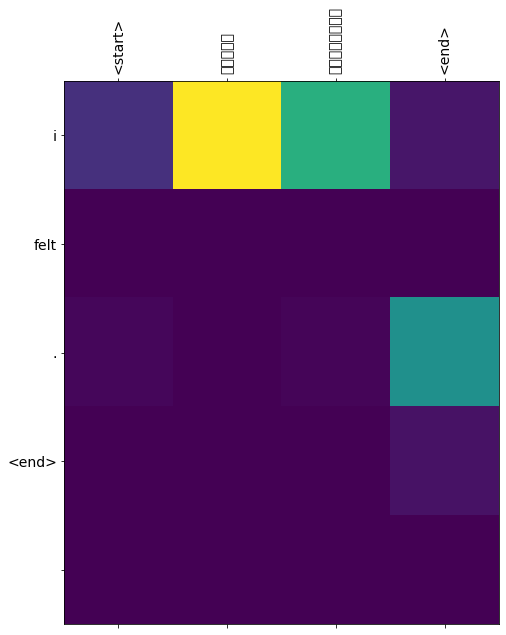

In [79]:
translate('나는 죽었어', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)